In [47]:
# !pip install seaborn
# !pip install openpyxl
#!pip install ccxt
#!pip install stockstats
#!pip install python-binance
#!conda install -c conda-forge ta-lib -y
#!sudo pip install --upgrade SciPy

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.14.0
  latest version: 23.1.0

Please update conda by running

    $ conda update -n base -c conda-forge conda



## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - ta-lib


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2022.12.7  |       ha878542_0         143 KB  conda-forge
    certifi-2022.12.7          |     pyhd8ed1ab_0         147 KB  conda-forge
    libblas-3.9.0              |16_linux64_openblas          13 KB  conda-forge
    libcblas-3.9.0             |16_linux64_openblas          13 KB  conda-forge
    libgfortran-ng-12.2.0      |      h69a702a_19          22 KB  conda-forge
    libgfortran5-12.2.0        |      h337968e_19         1.8 MB  conda-forge
    liblapack-3.9.0            |16_linux64_openblas          13 KB  conda-f

In [37]:
import numpy as np
import pandas as pd
import os, datetime
import tensorflow as tf
from tensorflow.python.keras.utils.np_utils import to_categorical
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import math
import matplotlib.pyplot as plt
import seaborn as sns
from script.transformer_timestep import *
#plt.style.use('seaborn')
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')

# EDA

In [4]:
label_cutoff = 0.005
batch_size = 32
seq_len = 128
d_k = 256
d_v = 256
n_heads = 12
ff_dim = 256

In [3]:
def label_cutoff(x, label_cutoff=0.005):
    # 0 = do nothing
    # 1 = buy
    # 2 = sell
    if abs(x) < 0.005:
        return 0
    elif x > 1:
        return 1
    else:
        return 2
    
# def one_hot_encoding(label):
#     if label == 0:
#         return np.array([1,0,0])
#     elif label ==1:
#         return np.array([0,1,0])
#     else:
#         return np.array([0,0,2])

In [38]:
BTC_raw = pd.read_excel('./data/BTC_multi_factor.xlsx')
# del BTC_raw['time']
# del BTC_raw['symbol']
# del BTC_raw['下週期幣種漲跌幅']

In [26]:
BTC_raw['close_return_z_score'] = (BTC_raw['漲跌幅'] - BTC_raw['漲跌幅'].mean())/BTC_raw['漲跌幅'].std()


In [42]:
BTC_raw.shape[0]

3421

In [43]:
BTC_raw

,time,symbol,open,high,low,close,volume,quote_volume,trade_num,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,上市天數,漲跌幅,下週期幣種漲跌幅,Bias_2,Cmo_2,Atr_2,Cci_2,Volume_2,Psy_2,ZhangDieFu_2,ZhenFu_2,Rsi_2,Ic_2,Bias_3,Cmo_3,Atr_3,Cci_3,Volume_3,Psy_3,ZhangDieFu_3,ZhenFu_3,Rsi_3,Ic_3,Bias_4,Cmo_4,Atr_4,Cci_4,Volume_4,Psy_4,ZhangDieFu_4,ZhenFu_4,Rsi_4,Ic_4,Bias_5,Cmo_5,Atr_5,Cci_5,Volume_5,Psy_5,ZhangDieFu_5,ZhenFu_5,Rsi_5,Ic_5,Bias_6,Cmo_6,Atr_6,Cci_6,Volume_6,Psy_6,ZhangDieFu_6,ZhenFu_6,Rsi_6,Ic_6,Bias_8,Cmo_8,Atr_8,Cci_8,Volume_8,Psy_8,ZhangDieFu_8,ZhenFu_8,Rsi_8,Ic_8,Bias_9,Cmo_9,Atr_9,Cci_9,Volume_9,Psy_9,ZhangDieFu_9,ZhenFu_9,Rsi_9,Ic_9,Bias_12,Cmo_12,Atr_12,Cci_12,Volume_12,Psy_12,ZhangDieFu_12,ZhenFu_12,Rsi_12,Ic_12,Bias_13,Cmo_13,Atr_13,Cci_13,Volume_13,Psy_13,ZhangDieFu_13,ZhenFu_13,Rsi_13,Ic_13,Bias_21,Cmo_21,Atr_21,Cci_21,Volume_21,Psy_21,ZhangDieFu_21,ZhenFu_21,Rsi_21,Ic_21,Bias_24,Cmo_24,Atr_24,Cci_24,Volume_24,Psy_24,ZhangDieFu_24,ZhenFu_24,Rsi_24,Ic_24,Bias_30,Cmo_30,Atr_30,Cci_30,Volume_30,Psy_30,ZhangDieFu_30,ZhenFu_30,Rsi_30,Ic_30,Bias_34,Cmo_34,Atr_34,Cci_34,Volume_34,Psy_34,ZhangDieFu_34,ZhenFu_34,Rsi_34,Ic_34,Bias_36,Cmo_36,Atr_36,Cci_36,Volume_36,Psy_36,ZhangDieFu_36,ZhenFu_36,Rsi_36,Ic_36,Bias_48,Cmo_48,Atr_48,Cci_48,Volume_48,Psy_48,ZhangDieFu_48,ZhenFu_48,Rsi_48,Ic_48,Bias_55,Cmo_55,Atr_55,Cci_55,Volume_55,Psy_55,ZhangDieFu_55,ZhenFu_55,Rsi_55,Ic_55,Bias_60,Cmo_60,Atr_60,Cci_60,Volume_60,Psy_60,ZhangDieFu_60,ZhenFu_60,Rsi_60,Ic_60,Bias_64,Cmo_64,Atr_64,Cci_64,Volume_64,Psy_64,ZhangDieFu_64,ZhenFu_64,Rsi_64,Ic_64,Bias_72,Cmo_72,Atr_72,Cci_72,Volume_72,Psy_72,ZhangDieFu_72,ZhenFu_72,Rsi_72,Ic_72,Bias_89,Cmo_89,Atr_89,Cci_89,Volume_89,Psy_89,ZhangDieFu_89,ZhenFu_89,Rsi_89,Ic_89,Bias_96,Cmo_96,Atr_96,Cci_96,Volume_96,Psy_96,ZhangDieFu_96,ZhenFu_96,Rsi_96,Ic_96
0,2019-09-08 16:00:00,BTC-USDT,10000.00,10412.65,10000.00,10391.63,3096.291,3.209630e+07,3754,0.039,4.033562e+02,1,0.039163,-0.023303,0.000000,NaN,0.039710,0.000000,1.000000,0,NaN,0.041265,NaN,1.000000,0.000000,NaN,0.039710,0.000000,1.000000,0.000000,NaN,0.041265,NaN,1.000000,0.000000,NaN,0.039710,0.000000,1.000000,0,NaN,0.041265,NaN,1.000000,0.000000,NaN,0.039710,0.000000,1.000000,0,NaN,0.041265,NaN,1.000000,0.000000,NaN,0.039710,0.000000,1.000000,0.000000,NaN,0.041265,NaN,1.000000,0.000000,NaN,0.039710,0.000000,1.000000,0.0,NaN,0.041265,NaN,1.000000,0.000000,NaN,0.039710,0.000000,1.000000,0.000000,NaN,0.041265,NaN,1.000000,0.000000,NaN,0.039710,0.000000,1.000000,0.000000,NaN,0.041265,NaN,1.000000,0.000000,NaN,0.039710,0.000000,1.000000,0.000000,NaN,0.041265,NaN,1.000000,0.000000,NaN,0.039710,0.000000,1.000000,0.000000,NaN,0.041265,NaN,1.00000,0.000000,NaN,0.039710,0.000000,1.000000,0.000000,NaN,0.041265,NaN,1.000000,0.000000,NaN,0.039710,0.000000,1.000000,0.000000,NaN,0.041265,NaN,1.000000,0.000000,NaN,0.039710,0.000000,1.000000,0.000000,NaN,0.041265,NaN,1.000000,0.000000,NaN,0.039710,0.000000,1.000000,0.000000,NaN,0.041265,NaN,1.000000,0.000000,NaN,0.039710,0.000000,1.000000,0.000000,NaN,0.041265,NaN,1.000000,0.000000,NaN,0.039710,0.000000,1.000000,0.000000,NaN,0.041265,NaN,1.000000,0.000000,NaN,0.039710,0.000000,1.000000,0.000000,NaN,0.041265,NaN,1.000000,0.000000,NaN,0.039710,0.000000,1.000000,0.0000,NaN,0.041265,NaN,1.000000,0.000000,NaN,0.039710,0.000000,1.000000,0.000000,NaN,0.041265,NaN,1.000000,0.000000,NaN,0.039710,0.000000,1.000000,0.000000,NaN,0.041265,NaN,1.000000,0.000000,NaN,0.039710,0.000000,1.000000,0.000000,NaN,0.041265,NaN,1.000000
1,2019-09-09 00:00:00,BTC-USDT,10391.63,10391.63,10092.71,10149.47,3444.238,3.539813e+07,4020,0.001,1.030921e+01,1,-0.023303,0.016236,-0.011789,-100.000000,0.034641,-17.722815,0.524460,0,NaN,0.041265,0.000000,1.000000,-0.011789,-100.000000,0.034641,-17.722815,0.524460,0.000000,NaN,0.041265,0.000000,1.000000,-0.011789,-100.000000,0.034641,-17.722815,0.524460,0,NaN,0.041265,0.000000,1.000000,-0.011789,-100.000000,0.034641,-17.722815,0.524460,0,NaN,0.041265,0.000000,1.000000,-0.011789,-100.000000,0.034641,-

<AxesSubplot:xlabel='漲跌幅'>

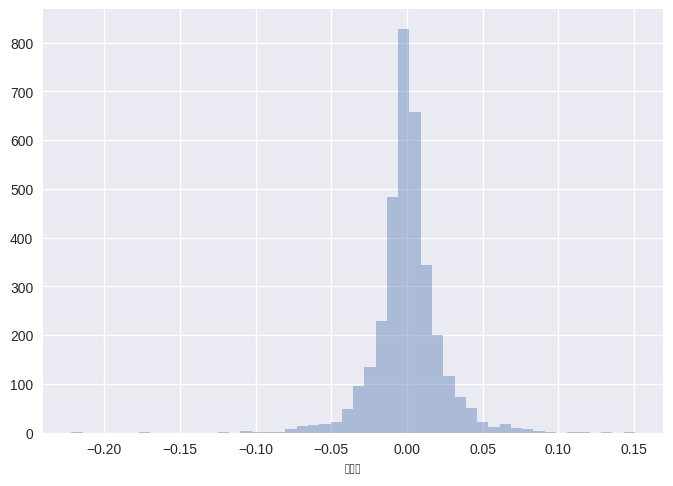

In [9]:
sns.distplot(a=BTC_raw['漲跌幅'], kde=False)

<AxesSubplot:xlabel='close_return_z_score'>

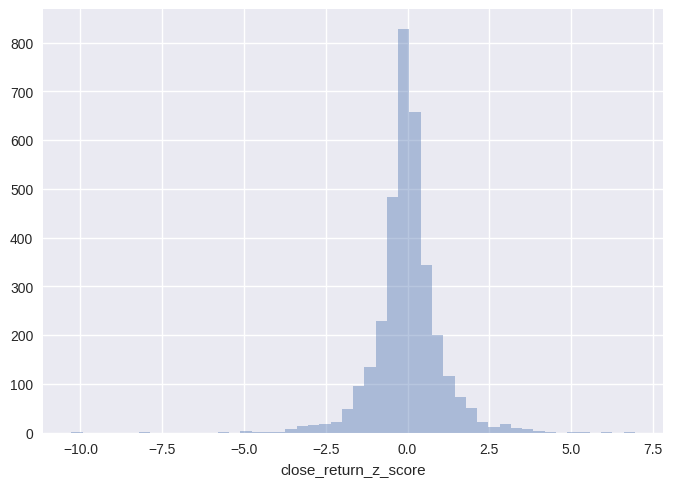

In [29]:
sns.distplot(a=BTC_raw['close_return_z_score'], kde=False)

In [35]:
for col in BTC_raw.columns[BTC_raw.corr()['close_return_z_score'].abs() >=0.5]:
    print(col)

漲跌幅
Bias_2
Cmo_2
Psy_2
ZhangDieFu_2
Rsi_2
Bias_3
Cci_3
Psy_3
ZhangDieFu_3
Rsi_3
Bias_4
Cci_4
Psy_4
Rsi_4
Bias_5
Cci_5
Psy_5
Bias_6
Psy_6
Bias_8
Psy_8
Bias_9
Psy_9
Psy_12
Psy_13
Psy_21
Psy_24
Psy_30
Psy_34
Psy_36
Psy_48
Psy_55
Psy_60
Psy_64
Psy_72
Psy_89
Psy_96
close_return_z_score


In [4]:
# print ("Shape Of The Before Ouliers: ",BTC_df.shape)
# n=1.5
# #IQR = Q3-Q1
# IQR = np.percentile(BTC_df['close'],75) - np.percentile(BTC_df['close'],25)
# #outlier = Q3 + n*IQR 
# BTC_df=BTC_df[BTC_df['close'] < np.percentile(BTC_df['close'],75)+n*IQR]
# #outlier = Q1 - n*IQR 
# BTC_df=BTC_df[BTC_df['close'] > np.percentile(BTC_df['close'],25)-n*IQR]
# print ("Shape Of The After Ouliers: ",BTC_df.shape)

NameError: name 'BTC_df' is not defined

In [5]:
BTC_df = BTC_raw.copy()
BTC_df.dropna(how='any', axis=0, inplace=True)
times = sorted(BTC_df.index.values)
last_10pct = sorted(BTC_df.index.values)[-int(0.1*len(times))] # Last 10% of series
last_20pct = sorted(BTC_df.index.values)[-int(0.2*len(times))] # Last 20% of series

In [6]:
# Min-max normalize price columns (0-1 range)
BTC_df[['open', 'high', 'low', 'close','volume','taker_buy_base_asset_volume','taker_buy_quote_asset_volume']] = BTC_df[['open', 'high', 'low', 'close','volume','taker_buy_base_asset_volume','taker_buy_quote_asset_volume']].rolling(10).mean()
BTC_df['open']   = BTC_df['open'].pct_change() # Create arithmetic returns column
BTC_df['high']   = BTC_df['high'].pct_change() # Create arithmetic returns column
BTC_df['low']    = BTC_df['low'].pct_change() # Create arithmetic returns column
BTC_df['close']  = BTC_df['close'].pct_change() # Create arithmetic returns column
BTC_df['volume'] = BTC_df['volume'].pct_change()
BTC_df['taker_buy_base_asset_volume']  = BTC_df['taker_buy_base_asset_volume'].pct_change()
BTC_df['taker_buy_quote_asset_volume'] = BTC_df['taker_buy_quote_asset_volume'].pct_change()
# one-hot encoding
#BTC_df['buy_sell_label'] = BTC_df['buy_sell_label'].apply(lambda x:one_hot_encoding(x))

BTC_df.dropna(how='any', axis=0, inplace=True)

min_return = min(BTC_df[(BTC_df.index < last_10pct)][['open', 'high', 'low', 'close']].min(axis=0))
max_return = max(BTC_df[(BTC_df.index < last_10pct)][['open', 'high', 'low', 'close']].max(axis=0))

# Min-max normalize price columns (0-1 range)
BTC_df['open'] = (BTC_df['open'] - min_return) / (max_return - min_return)
BTC_df['high'] = (BTC_df['high'] - min_return) / (max_return - min_return)
BTC_df['low'] = (BTC_df['low'] - min_return) / (max_return - min_return)
BTC_df['close'] = (BTC_df['close'] - min_return) / (max_return - min_return)
# close_scaler = MinMaxScaler().fit(BTC_df[(BTC_df.index < last_20pct)][['open', 'high', 'low', 'close']])
# BTC_df[['open', 'high', 'low', 'close']]  = close_scaler.transform(BTC_df[['open', 'high', 'low', 'close']] )



# # Min-max volume column
vol_min_return = min(BTC_df[(BTC_df.index < last_10pct)][['volume']].min(axis=0))
vol_max_return = max(BTC_df[(BTC_df.index < last_10pct)][['volume']].max(axis=0))
BTC_df['volume'] = (BTC_df['volume'] - vol_min_return) / (vol_max_return - vol_min_return)

# scaler = MinMaxScaler().fit(BTC_df[(BTC_df.index < last_20pct)][['volume']])
# BTC_df[['volume']] = scaler.transform(BTC_df[['volume']])


# # Min-max quote_volume column
quote_volume_min_return = min(BTC_df[(BTC_df.index < last_10pct)][['quote_volume']].min(axis=0))
quote_volume_max_return = max(BTC_df[(BTC_df.index < last_10pct)][['quote_volume']].max(axis=0))
BTC_df['quote_volume'] = (BTC_df['quote_volume'] - quote_volume_min_return) / (quote_volume_max_return - quote_volume_min_return)
# scaler = MinMaxScaler().fit(BTC_df[(BTC_df.index < last_20pct)][['quote_volume']])
# BTC_df[['quote_volume']] = scaler.transform(BTC_df[['quote_volume']])


# # # Min-max taker_buy_base_asset_volume column
taker_buy_base_asset_volume_min_return = min(BTC_df[(BTC_df.index < last_10pct)][['taker_buy_base_asset_volume']].min(axis=0))
taker_buy_base_asset_volume_max_return = max(BTC_df[(BTC_df.index < last_10pct)][['taker_buy_base_asset_volume']].max(axis=0))
BTC_df['taker_buy_base_asset_volume'] = (BTC_df['taker_buy_base_asset_volume'] - taker_buy_base_asset_volume_min_return) / (taker_buy_base_asset_volume_max_return - taker_buy_base_asset_volume_min_return)
# scaler = MinMaxScaler().fit(BTC_df[(BTC_df.index < last_20pct)][['taker_buy_base_asset_volume']])
# BTC_df[['taker_buy_base_asset_volume']] = scaler.transform(BTC_df[['taker_buy_base_asset_volume']])

# # # Min-max taker_buy_quote_asset_volume column
taker_buy_quote_asset_volume_min_return = min(BTC_df[(BTC_df.index < last_10pct)][['taker_buy_quote_asset_volume']].min(axis=0))
taker_buy_quote_asset_volume_max_return = max(BTC_df[(BTC_df.index < last_10pct)][['taker_buy_quote_asset_volume']].max(axis=0))
BTC_df['taker_buy_quote_asset_volume'] = (BTC_df['taker_buy_base_asset_volume'] - taker_buy_quote_asset_volume_min_return) / (taker_buy_quote_asset_volume_max_return - taker_buy_quote_asset_volume_min_return)
# scaler = MinMaxScaler().fit(BTC_df[(BTC_df.index < last_20pct)][['taker_buy_quote_asset_volume']])
# BTC_df[['taker_buy_quote_asset_volume']] = scaler.transform(BTC_df[['taker_buy_quote_asset_volume']])

# # # Min-max trade_num column
trade_num_min_return = min(BTC_df[(BTC_df.index < last_10pct)][['trade_num']].min(axis=0))
trade_num_max_return = max(BTC_df[(BTC_df.index < last_10pct)][['trade_num']].max(axis=0))
BTC_df['trade_num'] = (BTC_df['trade_num'] - trade_num_min_return) / (trade_num_max_return - trade_num_min_return)

up_and_down_min = min(BTC_df[(BTC_df.index < last_10pct)][['漲跌幅']].min(axis=0))
up_and_down_max = max(BTC_df[(BTC_df.index < last_10pct)][['漲跌幅']].max(axis=0))
BTC_df['漲跌幅'] = (BTC_df['漲跌幅'] - up_and_down_min) / (up_and_down_max - up_and_down_min)

# 
# scaler = MinMaxScaler().fit(BTC_df[(BTC_df.index < last_20pct)][BTC_df.columns[11:-1]])
# BTC_df[BTC_df.columns[11:-1]] = scaler.transform(BTC_df[BTC_df.columns[11:-1]])

In [7]:
filter_columns_1 = [col for col in BTC_df.columns[BTC_df.corr()['漲跌幅'].abs() >=0.1]]
BTC_df = BTC_df[filter_columns_1]

In [8]:
BTC_df.head()

,high,low,close,漲跌幅,Bias_2,Cmo_2,Cci_2,Psy_2,ZhangDieFu_2,Rsi_2,Ic_2,Bias_3,Cmo_3,Cci_3,Psy_3,ZhangDieFu_3,Rsi_3,Bias_4,Cmo_4,Cci_4,Psy_4,ZhangDieFu_4,Rsi_4,Bias_5,Cmo_5,Cci_5,Psy_5,ZhangDieFu_5,Rsi_5,Bias_6,Cmo_6,Cci_6,Psy_6,ZhangDieFu_6,Rsi_6,Bias_8,Cmo_8,Cci_8,Psy_8,ZhangDieFu_8,Rsi_8,Bias_9,Cmo_9,Cci_9,Psy_9,ZhangDieFu_9,Rsi_9,Bias_12,Cmo_12,Cci_12,Psy_12,ZhangDieFu_12,Rsi_12,Bias_13,Cmo_13,Cci_13,Psy_13,ZhangDieFu_13,Rsi_13,Bias_21,Cmo_21,Cci_21,Psy_21,ZhangDieFu_21,Rsi_21,Bias_24,Cmo_24,Cci_24,Psy_24,ZhangDieFu_24,Rsi_24,Bias_30,Cmo_30,Cci_30,Psy_30,ZhangDieFu_30,Rsi_30,Bias_34,Cmo_34,Cci_34,Psy_34,ZhangDieFu_34,Rsi_34,Bias_36,Cmo_36,Cci_36,Psy_36,ZhangDieFu_36,Rsi_36,Bias_48,Cmo_48,Cci_48,Psy_48,ZhangDieFu_48,Rsi_48,Bias_55,Cmo_55,Cci_55,Psy_55,ZhangDieFu_55,Rsi_55,Bias_60,Cmo_60,Cci_60,Psy_60,ZhangDieFu_60,Rsi_60,Bias_64,Cmo_64,Cci_64,Psy_64,ZhangDieFu_64,Rsi_64,Bias_72,Cmo_72,Cci_72,Psy_72,ZhangDieFu_72,Rsi_72,Bias_89,Cmo_89,Cci_89,Psy_89,ZhangDieFu_89,Rsi_89,Bias_96,Cmo_96,Cci_96,Psy_96,ZhangDieFu_96,Rsi_96
106,0.525455,0.527104,0.525567,0.604421,0.001660,-64.328320,2.224757,50,-0.011810,43.372306,0.980384,-0.002871,-7.275575,-45.605468,33.333333,-0.002066,43.035458,-0.002670,0.763478,-56.786518,25,0.000235,43.462420,-0.002090,-20.562998,-63.021881,20,-0.007961,44.351822,-0.003073,-9.589810,-64.111951,16.666667,-0.004100,45.421620,-0.002121,-7.430015,-22.454708,12.5,-0.004655,47.322207,-0.002403,-14.657682,-22.831470,11.111111,-0.009909,48.010634,-0.007480,-37.117537,-51.521998,8.333333,-0.035895,49.043349,-0.009725,-29.131703,-49.121659,7.692308,-0.030094,49.119850,-0.004838,26.527931,-22.640062,4.761905,0.055987,47.799158,0.001750,18.598942,2.862048,4.166667,0.043223,47.094771,0.006577,8.216716,20.846301,3.333333,0.021603,45.860737,0.007590,-1.926911,18.732638,2.941176,-0.005983,45.197360,0.007239,3.913279,15.001909,2.777778,0.013137,44.909217,0.009665,2.051188,7.631401,2.083333,0.011010,43.638593,0.011393,-2.380873,6.852473,1.818182,-0.015172,43.147558,0.007245,-20.850188,3.334768,1.666667,-0.148990,42.869173,-0.004566,-23.426106,-3.682223,1.5625,-0.171691,42.679473,-0.026868,-24.161637,-17.386703,1.388889,-0.182572,42.367511,-0.061666,-23.087618,-43.890930,1.123596,-0.198478,41.904432,-0.073020,-18.712803,-54.822522,1.041667,-0.176287,41.765554
107,0.501286,0.544271,0.539435,0.579016,-0.003061,-29.623945,-33.289201,0,-0.002799,23.657268,0.979713,-0.002974,-73.149187,-23.767928,0.000000,-0.017841,30.892437,-0.006733,-23.649543,-54.408866,0,-0.008157,34.612908,-0.007018,-15.917407,-66.020598,0,-0.005870,37.335044,-0.006827,-31.306553,-64.239078,0.000000,-0.014015,39.576110,-0.008150,-0.836305,-49.752153,0.0,-0.000494,42.933095,-0.007305,-15.611917,-34.753559,0.000000,-0.010730,44.122342,-0.010733,-35.209839,-60.646278,0.000000,-0.033338,46.210250,-0.012509,-40.724223,-58.339038,0.000000,-0.041779,46.541683,-0.011346,5.504666,-34.631676,0.000000,0.009410,46.391421,-0.005641,13.720373,-11.888447,0.000000,0.031956,45.907477,-0.000013,5.087554,9.121454,0.000000,0.013579,44.956909,0.001464,-0.260398,12.120319,0.000000,-0.000804,44.414141,0.001021,0.762923,9.127342,0.000000,0.002564,44.173516,0.003026,4.348048,5.297256,0.000000,0.023243,43.085571,0.005504,-2.373603,5.533472,0.000000,-0.015217,42.655755,0.003692,-18.812094,3.434552,0.000000,-0.134155,42.410204,-0.007569,-22.706724,-3.309689,0.0000,-0.166852,42.242176,-0.029760,-25.050968,-16.913421,0.000000,-0.189493,41.964708,-0.064922,-23.302264,-43.402547,0.000000,-0.201384,41.550474,-0.076449,-22.317248,-54.445743,0.000000,-0.200946,41.425753
108,0.554423,0.547534,0.555570,0.625873,0.005697,30.216224,31.288408,50,0.005285,71.687060,0.980192,0.005560,41.330400,36.608537,33.333333,0.008628,61.387524,0.006325,-18.479931,28.516245,25,-0.006587,56.599218,0.003716,6.996252,1.614079,20,0.003208,54.226328,0.003631,11.439483,-0.571456,16.666667,0.005522,53.093304,0.003069,1.933658,-9.625081,12.5,0.001164,52.356683,0.002857,15.533731,-7.141317,11.111111,0.010959,52.241887,0.002

In [9]:

df_train = BTC_df[(BTC_df.index < last_10pct)]  # Training data are 80% of total data
df_val   = BTC_df[(BTC_df.index >= last_20pct) & (BTC_df.index < last_10pct)]
df_test  = BTC_df[(BTC_df.index >= last_10pct)]

In [10]:
# Convert pandas columns into arrays
train_data = df_train.values
val_data = df_val.values
test_data = df_test.values
print('Training data shape: {}'.format(train_data.shape))
print('Validation data shape: {}'.format(val_data.shape))
print('Test data shape: {}'.format(test_data.shape))

Training data shape: (2983, 131)
Validation data shape: (333, 131)
Test data shape: (332, 131)


KeyError: '上市天數'

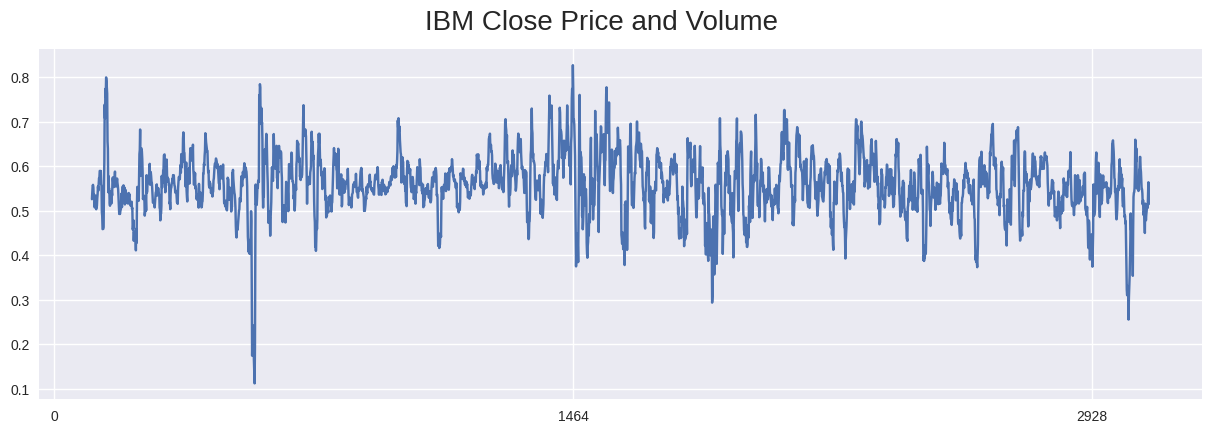

In [18]:
fig = plt.figure(figsize=(15,10))
st = fig.suptitle("IBM Close Price and Volume", fontsize=20)
st.set_y(0.92)

ax1 = fig.add_subplot(211)
ax1.plot(df_train['close'], label='BTC Close Price')
ax1.set_xticks(range(0, df_train.shape[0], 1464))
ax1.set_xticklabels(df_train['上市天數'].loc[::1464])
ax1.set_ylabel('Close Price', fontsize=18)
ax1.legend(loc="upper left", fontsize=12)

ax2 = fig.add_subplot(212)
ax2.plot(df_train['volume'], label='BTC Volume')
ax2.set_xticks(range(0, df_train.shape[0], 1464))
ax2.set_xticklabels(df_train['上市天數'].loc[::1464])
ax2.set_ylabel('volume', fontsize=18)
ax2.legend(loc="upper left", fontsize=12)

In [19]:
train_data[0,10]

0.00336462287580996

In [11]:
X_train, y_train = [], []
for i in range(seq_len, len(train_data)):
    X_train.append(train_data[i-seq_len:i]) # Chunks of training data with a length of 128 df-rows
    y_train.append(train_data[:, 2][i]) # close
    #y_train.append(train_data[:, 10][i])#Value of 222th column (buy_sell_label) of df-row 128+1
#X_train, y_train = np.array(X_train), to_categorical(y_train)
X_train, y_train = np.array(X_train), np.array(y_train)

# ###############################################################################

# Validation data
X_val, y_val = [], []
for i in range(seq_len, len(val_data)):
    X_val.append(val_data[i-seq_len:i])
    y_val.append(val_data[:, 2][i])
#X_val, y_val = np.array(X_val), to_categorical(y_val)
X_val, y_val = np.array(X_val), np.array(y_val)
# ###############################################################################

# Test data
X_test, y_test = [], []
for i in range(seq_len, len(test_data)):
    X_test.append(test_data[i-seq_len:i])
    y_test.append(test_data[:, 2][i])    
#X_test, y_test = np.array(X_test), to_categorical(y_test)
X_test, y_test = np.array(X_test), np.array(y_test)


print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(2855, 128, 131) (2855,)
(205, 128, 131) (205,)
(204, 128, 131) (204,)


In [14]:
feature_count = X_train.shape[2]
def create_model():
    '''Initialize time and transformer layers'''
    time_embedding = Time2Vector(seq_len)
    attn_layer1 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
    attn_layer2 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
    attn_layer3 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)

    '''Construct model'''
    in_seq = Input(shape=(seq_len, feature_count))
    x = time_embedding(in_seq)
    x = Concatenate(axis=-1)([in_seq, x])
    x = attn_layer1((x, x, x))
    x = attn_layer2((x, x, x))
    x = attn_layer3((x, x, x))
    x = GlobalAveragePooling1D(data_format='channels_first')(x)
    x = Dropout(0.1)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.1)(x)
    out = Dense(1, activation='linear')(x)
    
    #optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)
    model = Model(inputs=in_seq, outputs=out)
    optimizer = tf.keras.optimizers.AdamW(learning_rate=0.001,weight_decay=0.004)
    #model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae','mape'])
    return model

model = create_model()
model.summary()

callback = tf.keras.callbacks.ModelCheckpoint('./model_weight/transformer_btc_multi_factor_ft_filtered_prediction.hdf5', 
                                              monitor='val_loss', 
                                              save_best_only=True, 
                                              verbose=1)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 131)]   0           []                               
                                                                                                  
 time2_vector_1 (Time2Vector)   (None, 128, 2)       512         ['input_2[0][0]']                
                                                                                                  
 concatenate_1 (Concatenate)    (None, 128, 133)     0           ['input_2[0][0]',                
                                                                  'time2_vector_1[0][0]']         
                                                                                                  
 transformer_encoder_3 (Transfo  (None, 128, 133)    1712670     ['concatenate_1[0][0]',    

In [16]:
history = model.fit(X_train, y_train, 
                    batch_size=batch_size, 
                    epochs=35, 
                    callbacks=[callback],
                    validation_data=(X_val, y_val))


Epoch 1/35


2023-02-27 06:42:01.817430: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:417] Loaded runtime CuDNN library: 8.2.0 but source was compiled with: 8.6.0.  CuDNN library needs to have matching major version and equal or higher minor version. If using a binary install, upgrade your CuDNN library.  If building from sources, make sure the library loaded at runtime is compatible with the version specified during compile configuration.
2023-02-27 06:42:01.820086: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at conv_ops.cc:1068 : UNIMPLEMENTED: DNN library is not found.
2023-02-27 06:42:01.820206: I tensorflow/core/common_runtime/executor.cc:1227] [/job:localhost/replica:0/task:0/device:GPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): UNIMPLEMENTED: DNN library is not found.
	 [[{{node model_1/transformer_encoder_3/conv1d/Conv1D}}]]


UnimplementedError: Graph execution error:

Detected at node 'model_1/transformer_encoder_3/conv1d/Conv1D' defined at (most recent call last):
    File "/opt/conda/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/opt/conda/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/opt/conda/lib/python3.8/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/opt/conda/lib/python3.8/site-packages/traitlets/config/application.py", line 978, in launch_instance
      app.start()
    File "/opt/conda/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 712, in start
      self.io_loop.start()
    File "/opt/conda/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/opt/conda/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/opt/conda/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/opt/conda/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/conda/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/opt/conda/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/opt/conda/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/opt/conda/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "/opt/conda/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/conda/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2885, in run_cell
      result = self._run_cell(
    File "/opt/conda/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2940, in _run_cell
      return runner(coro)
    File "/opt/conda/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/conda/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3139, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/opt/conda/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3318, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/opt/conda/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3378, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_17799/245316840.py", line 1, in <module>
      history = model.fit(X_train, y_train,
    File "/home/jiansiaoyu/.local/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/jiansiaoyu/.local/lib/python3.8/site-packages/keras/engine/training.py", line 1685, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/jiansiaoyu/.local/lib/python3.8/site-packages/keras/engine/training.py", line 1284, in train_function
      return step_function(self, iterator)
    File "/home/jiansiaoyu/.local/lib/python3.8/site-packages/keras/engine/training.py", line 1268, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/jiansiaoyu/.local/lib/python3.8/site-packages/keras/engine/training.py", line 1249, in run_step
      outputs = model.train_step(data)
    File "/home/jiansiaoyu/.local/lib/python3.8/site-packages/keras/engine/training.py", line 1050, in train_step
      y_pred = self(x, training=True)
    File "/home/jiansiaoyu/.local/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/jiansiaoyu/.local/lib/python3.8/site-packages/keras/engine/training.py", line 558, in __call__
      return super().__call__(*args, **kwargs)
    File "/home/jiansiaoyu/.local/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/jiansiaoyu/.local/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/jiansiaoyu/.local/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/jiansiaoyu/.local/lib/python3.8/site-packages/keras/engine/functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/home/jiansiaoyu/.local/lib/python3.8/site-packages/keras/engine/functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/home/jiansiaoyu/.local/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/jiansiaoyu/.local/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/jiansiaoyu/.local/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/mnt/home/jiansiaoyu/side_project/CapMarket/bot_experiments/script/transformer_timestep.py", line 199, in call
      ff_layer = self.ff_conv1D_1(attn_layer)
    File "/home/jiansiaoyu/.local/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/jiansiaoyu/.local/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/jiansiaoyu/.local/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/jiansiaoyu/.local/lib/python3.8/site-packages/keras/layers/convolutional/base_conv.py", line 290, in call
      outputs = self.convolution_op(inputs, self.kernel)
    File "/home/jiansiaoyu/.local/lib/python3.8/site-packages/keras/layers/convolutional/base_conv.py", line 262, in convolution_op
      return tf.nn.convolution(
Node: 'model_1/transformer_encoder_3/conv1d/Conv1D'
DNN library is not found.
	 [[{{node model_1/transformer_encoder_3/conv1d/Conv1D}}]] [Op:__inference_train_function_108149]

In [25]:
model = tf.keras.models.load_model('./model_weight/transformer_btc_multi_factor_ft_filtered_prediction.hdf5',
                                   custom_objects={'Time2Vector': Time2Vector, 
                                                   'SingleAttention': SingleAttention,
                                                   'MultiAttention': MultiAttention,
                                                   'TransformerEncoder': TransformerEncoder})

###############################################################################
'''Calculate predictions and metrics'''

#Calculate predication for training, validation and test data
train_pred = model.predict(X_train)
val_pred   = model.predict(X_val)
test_pred  = model.predict(X_test)

#Print evaluation metrics for all datasets
train_eval = model.evaluate(X_train, y_train, verbose=0)
val_eval   = model.evaluate(X_val, y_val, verbose=0)
test_eval  = model.evaluate(X_test, y_test, verbose=0)
print(' ')
print('Evaluation metrics')
print('Training Data - Loss: {:.4f}, MAE: {:.4f}'.format(train_eval[0], train_eval[1]))
print('Validation Data - Loss: {:.4f}, MAE: {:.4f}'.format(val_eval[0], val_eval[1]))
print('Test Data - Loss: {:.4f}, MAE: {:.4f}'.format(test_eval[0], test_eval[1]))

 
Evaluation metrics
Training Data - Loss: 0.0006, MAE: 0.0177
Validation Data - Loss: 0.0004, MAE: 0.0167
Test Data - Loss: 0.0008, MAE: 0.0221


In [15]:
y_test

NameError: name 'y_test' is not defined

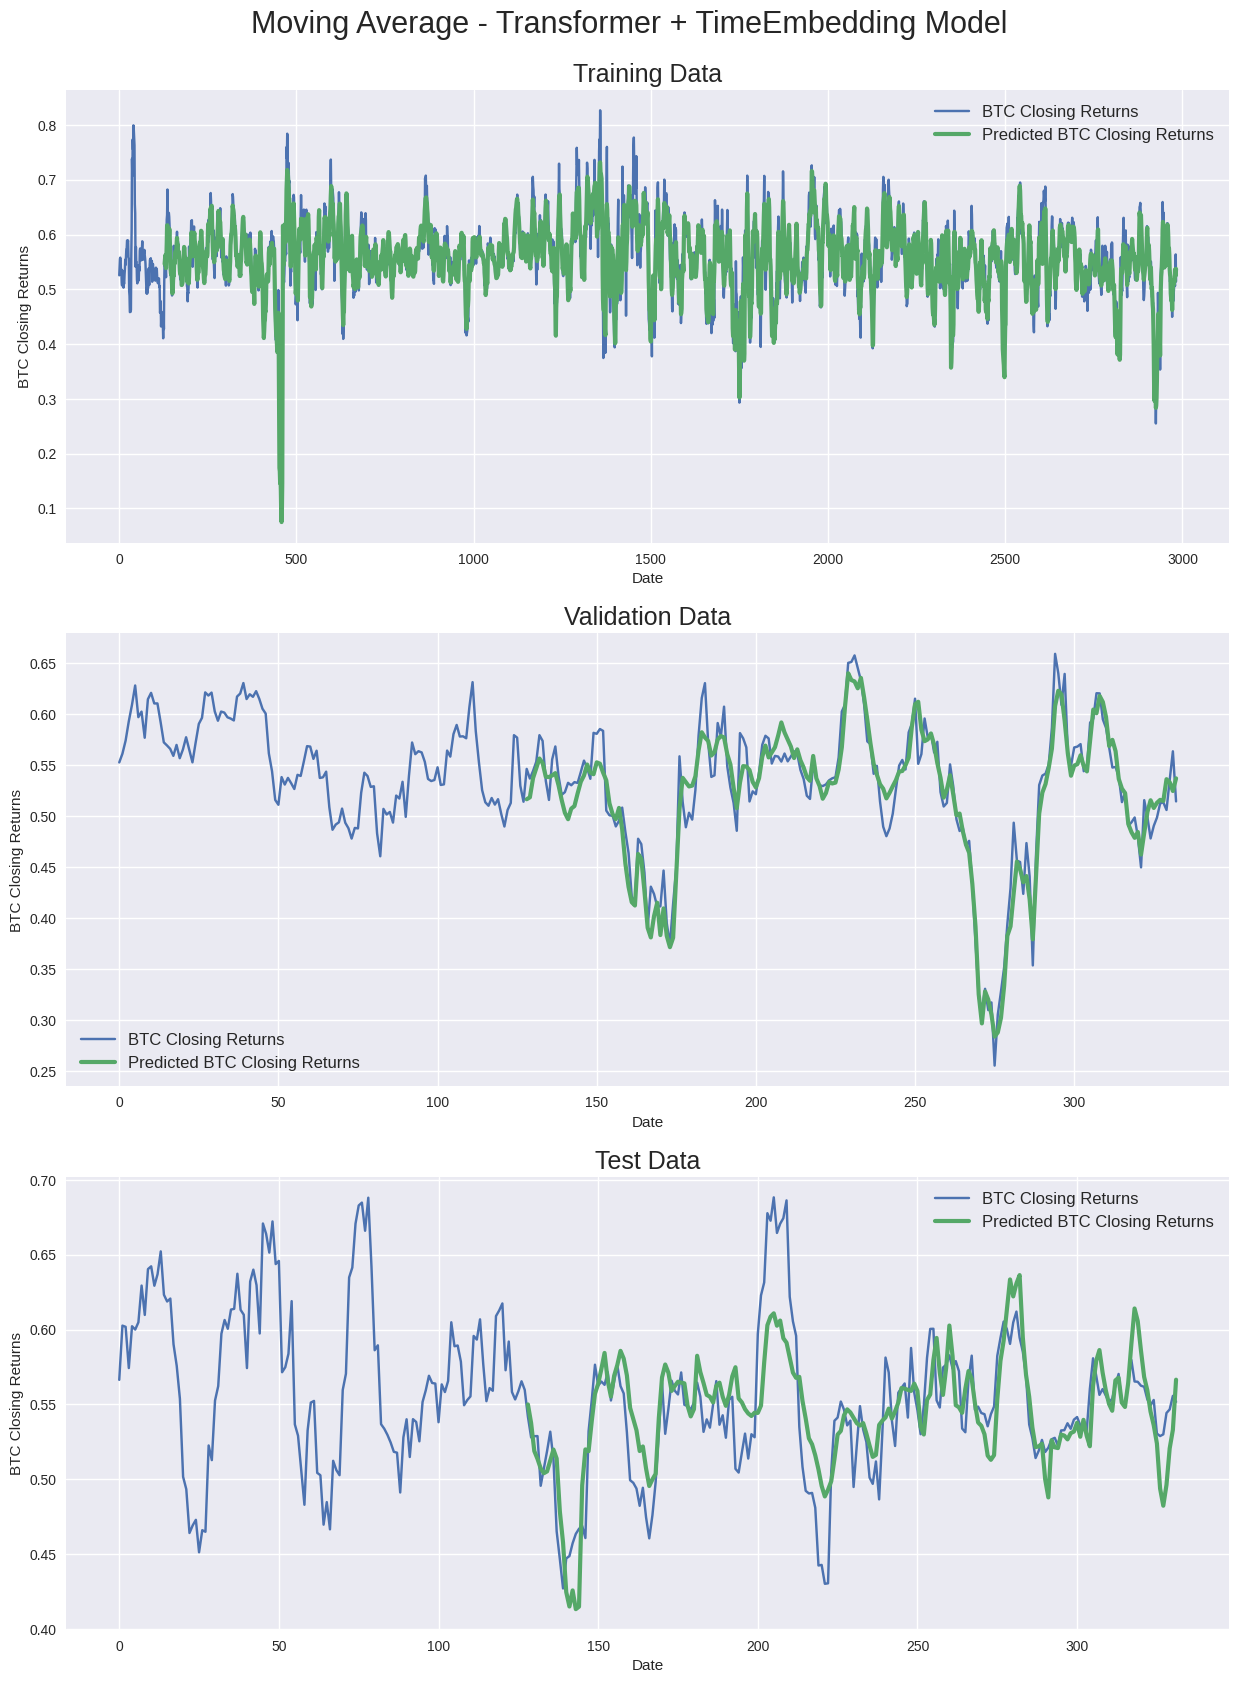

In [26]:

#'''Display results'''

fig = plt.figure(figsize=(15,20))
st = fig.suptitle("Moving Average - Transformer + TimeEmbedding Model", fontsize=22)
st.set_y(0.92)

#Plot training data results
ax11 = fig.add_subplot(311)
ax11.plot(train_data[:, 2], label='BTC Closing Returns')
ax11.plot(np.arange(seq_len, train_pred.shape[0]+seq_len), train_pred, linewidth=3, label='Predicted BTC Closing Returns')
ax11.set_title("Training Data", fontsize=18)
ax11.set_xlabel('Date')
ax11.set_ylabel('BTC Closing Returns')
ax11.legend(loc="best", fontsize=12)

#Plot validation data results
ax21 = fig.add_subplot(312)
ax21.plot(val_data[:, 2], label='BTC Closing Returns')
ax21.plot(np.arange(seq_len, val_pred.shape[0]+seq_len), val_pred, linewidth=3, label='Predicted BTC Closing Returns')
ax21.set_title("Validation Data", fontsize=18)
ax21.set_xlabel('Date')
ax21.set_ylabel('BTC Closing Returns')
ax21.legend(loc="best", fontsize=12)

#Plot test data results
ax31 = fig.add_subplot(313)
ax31.plot(test_data[:, 2], label='BTC Closing Returns')
ax31.plot(np.arange(seq_len, test_pred.shape[0]+seq_len), test_pred, linewidth=3, label='Predicted BTC Closing Returns')
ax31.set_title("Test Data", fontsize=18)
ax31.set_xlabel('Date')
ax31.set_ylabel('BTC Closing Returns')
ax31.legend(loc="best", fontsize=12)

In [ ]:
y_train[:10]

In [ ]:
btc_corr.style.background_gradient(cmap='Blues')

In [1]:
import numpy as np
import pandas as pd
import os, datetime
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
import math
import matplotlib.pyplot as plt
plt.style.use('seaborn')

import warnings
warnings.filterwarnings('ignore')
from script.transformer_timestep import *

2023-02-27 06:07:00.743104: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


Tensorflow version: 2.5.0


In [9]:
filter_columns_1

['high',
 'low',
 'close',
 '漲跌幅',
 'Bias_2',
 'Cmo_2',
 'Cci_2',
 'Psy_2',
 'ZhangDieFu_2',
 'Rsi_2',
 'Ic_2',
 'Bias_3',
 'Cmo_3',
 'Cci_3',
 'Psy_3',
 'ZhangDieFu_3',
 'Rsi_3',
 'Bias_4',
 'Cmo_4',
 'Cci_4',
 'Psy_4',
 'ZhangDieFu_4',
 'Rsi_4',
 'Bias_5',
 'Cmo_5',
 'Cci_5',
 'Psy_5',
 'ZhangDieFu_5',
 'Rsi_5',
 'Bias_6',
 'Cmo_6',
 'Cci_6',
 'Psy_6',
 'ZhangDieFu_6',
 'Rsi_6',
 'Bias_8',
 'Cmo_8',
 'Cci_8',
 'Psy_8',
 'ZhangDieFu_8',
 'Rsi_8',
 'Bias_9',
 'Cmo_9',
 'Cci_9',
 'Psy_9',
 'ZhangDieFu_9',
 'Rsi_9',
 'Bias_12',
 'Cmo_12',
 'Cci_12',
 'Psy_12',
 'ZhangDieFu_12',
 'Rsi_12',
 'Bias_13',
 'Cmo_13',
 'Cci_13',
 'Psy_13',
 'ZhangDieFu_13',
 'Rsi_13',
 'Bias_21',
 'Cmo_21',
 'Cci_21',
 'Psy_21',
 'ZhangDieFu_21',
 'Rsi_21',
 'Bias_24',
 'Cmo_24',
 'Cci_24',
 'Psy_24',
 'ZhangDieFu_24',
 'Rsi_24',
 'Bias_30',
 'Cmo_30',
 'Cci_30',
 'Psy_30',
 'ZhangDieFu_30',
 'Rsi_30',
 'Bias_34',
 'Cmo_34',
 'Cci_34',
 'Psy_34',
 'ZhangDieFu_34',
 'Rsi_34',
 'Bias_36',
 'Cmo_36',
 'Cci_36',
 '

In [8]:
df = pd.read_excel('./data/BTC_multi_factor.xlsx')
df_normalized = df_mulit_factor_nomalization(df)
df_normalized = df_normalized[filter_columns_1]

In [10]:
times = sorted(df_normalized.index.values)
last_10pct = sorted(df_normalized.index.values)[-int(0.1*len(times))] # Last 10% of series
last_20pct = sorted(df_normalized.index.values)[-int(0.2*len(times))] # Last 20% of series
df_train = df_normalized[(df_normalized.index < last_10pct)]  # Training data are 80% of total data
df_val   = df_normalized[(df_normalized.index >= last_20pct) & (df_normalized.index < last_10pct)]
df_test  = df_normalized[(df_normalized.index >= last_10pct)]

In [11]:
model = load_fine_tune_model(weight_path='./model_weight/transformer_btc_multi_factor_ft_filtered_prediction.hdf5')


2023-02-27 06:08:31.316834: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2023-02-27 06:08:31.327832: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:21:00.0 name: NVIDIA Quadro RTX 8000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 47.46GiB deviceMemoryBandwidth: 625.94GiB/s
2023-02-27 06:08:31.327881: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-02-27 06:08:31.331963: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-02-27 06:08:31.332051: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2023-02-27 06:08:31.333235: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuff

In [13]:
df_train = BTC_df[(BTC_df.index < last_10pct)]  # Training data are 80% of total data
df_val   = BTC_df[(BTC_df.index >= last_20pct) & (BTC_df.index < last_10pct)]
df_test  = BTC_df[(BTC_df.index >= last_10pct)]

In [14]:
predicted_train = multi_facter_transformer_prediction_model(model, df_train, (df_train.shape[0]-128))
predicted_val   = multi_facter_transformer_prediction_model(model, df_val, (df_val.shape[0]-128))
predicted_test  = multi_facter_transformer_prediction_model(model, df_test, (df_test.shape[0]-128))

KeyError: 'close_original'